In [18]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go
import glob

In [19]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 's:\\131-DPE\\131.1-Temporaire\\131.1.1-Espace commun\\zone transfert temporaire\\ITESE Grenoble\\Stage Justine\\Code git\\wavelet_decomposition')

In [20]:
# Importing functions 
from utilities import import_excel, optimize_enr, format_load_data

from calc_translations import calculate_all_translations, calc_all_translations_justine
from wavelet_decomposition import compute_wavelet_coefficient_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct

from plots import plot_betas_heatmap
# from plots import plot_EPN
from calc_EPN import calc_epn
from miscelaneous_functions import create_directory

In [21]:
import numpy as np
import pickle as pkl
import os
from scipy import sparse
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize

In [22]:
path_input_data = '../input_time_series/'
dpd = 24 # data per day in the time serie
dpy = 365 # data per year :  cut the leap years to 365 years

ndpd = 64 # new data per day for hourly data (for the interpolation)
signal_length = ndpd * dpy


In [23]:
countries = pd.read_csv('../countries_codes_and_coordinates_adapted.csv' , sep = ',', index_col = 0).index.to_list()

usa_states_codes = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'Californie',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Floride', 'GA': 'Géorgie',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiane', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'Nouveau-Mexique', 'NY': 'New York', 'NC': 'Caroline du Nord', 'ND': 'Dakota du Nord', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvanie', 'RI': 'Rhode Island', 'SC': 'Caroline du Sud',
    'SD': 'Dakota du Sud', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginie', 'WA': 'Washington', 'WV': 'Virginie-Occidentale', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}
brazil_states_codes = [
    'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 
    'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 
    'SE', 'SP', 'TO'
]

canadian_province_codes = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']

china_province_abbreviations = [
    "CN061", "CN031", "CN050", "CN033", "CN036", "CN053", "CN037", "CN021", "CN054", "CN062", "CN081", "CN063", 
    "CN011", "CN011", "CN015", "CN042", "CN034", "CN052", "CN064", "CN032", "CN065", "CN014", "CN043", "CN051", 
    "CN045", "CN022", "CN013", "CN012", "CN044", "CN035", "CN023", "CN041", "CN046"
]


australia_states_codes = ['NSW', 'QLD', 'SA','WA','VIC','TAS', 'NT', 'NSW','QLD', 'SA', 'WA','VIC','TAS','NT']

russia_states_codes = pd.read_excel('codes_russia.xlsx')['shapeISO'].to_list()

dict_list = {'China': china_province_abbreviations, 'Australia':australia_states_codes, 'Russia': russia_states_codes, 'Canada':canadian_province_codes,
             'Brazil':brazil_states_codes, 'United States':usa_states_codes}

# Calcul des translations consommation

In [38]:
for country in countries:
    file_name = format_load_data(country)
    Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
    
    # Options of the wavelet decomposition
    vy = 6  # number of vectors per years (child wavelets)
    vw = 3  # vectors per week
    vd = 6  # vectors per day

    # Time scales of the wavelet decomposition
    time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
                8760.] # cycles length, in hours

    translation_name = f'{country}_PLEXOS_bis'
    translation_results_root = 'translation_calculation_results/' + translation_name 

    path_trans = translation_results_root + '/translation/'
    create_directory(path_trans)
    path_matrix = translation_results_root + '/matrix/'
    create_directory(path_matrix)

    wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
    input_data = Load_ts

    #Calculate translations
    trans = calc_all_translations_justine(path_trans, translation_name,
                                    ndpd, dpy, input_data, wl_shape='square', 
                                    recompute_translation= False)

Directory 'translation_calculation_results/Afghanistan_PLEXOS_bis/translation/' created successfully.
Directory 'translation_calculation_results/Afghanistan_PLEXOS_bis/matrix/' created successfully.
Computing translation...
Best scalar product :[3569.35064866]
-44.60456766743653
-40.9511154368094
-35.55422247606435
-28.413888785201422
-19.164584062524277
-7.075247704641001
7.85412028844841
24.27367974777714
41.50851058886404
59.558612811709146
74.29580749006308
85.72009462392583
93.12046379522853
95.07489416783841
91.58338574175545
84.11947290618382
73.41992285572276
59.48473559037225
44.66255897267691
28.953393002636716
12.448234675189187
-4.670922019791526
-22.404077082305456
-40.505384393827185
-58.85192089509459
-77.44368658610765
-95.88183701109125
-114.16637217004536
-132.17699095101898
-149.67309113011092
-166.65467270732128
-183.42680696398196
-200.1420295407582
-216.8003404376501
-234.72366379636333
-253.91199961689782
-274.7629584974704
-298.07176163451317
-323.83840902802626

# Calcul des translations PV

In [39]:
# Countries only
for country_name in countries:
    file_name = format_load_data(country_name)
    folder = path_input_data + f'/{country_name}'
    partie_name_file = f'grid_locations_averaged_pv_{country_name}_2021.xlsx' 

    chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
    fichiers_trouves = glob.glob(chemin_pattern)
    print(fichiers_trouves)
    if len(fichiers_trouves)!=0:
        file_name = fichiers_trouves[0].split('/',2)[-1]
        PV_ts = import_excel(path_input_data,file_name, 
                                        dpd ,ndpd, dpy, 
                                        interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day

    
        # Options of the wavelet decomposition
        vy = 6  # number of vectors per years (child wavelets)
        vw = 3  # vectors per week
        vd = 6  # vectors per day

        # Time scales of the wavelet decomposition
        time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
                    8760.] # cycles length, in hours

        translation_name = f'{country_name}_PV_ninja_bis'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = PV_ts

        #Calculate translations
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)
    else :
        continue


['../input_time_series//Afghanistan\\ren_ninja_1_grid_locations_averaged_pv_Afghanistan_2021.xlsx']
Directory 'translation_calculation_results/Afghanistan_PV_ninja_bis/translation/' created successfully.
Directory 'translation_calculation_results/Afghanistan_PV_ninja_bis/matrix/' created successfully.
Computing translation...
Best scalar product :[334.8495]
755.3710000000076
771.0630000000075
781.1690000000056
785.6890000000016
784.776499999997
778.7384999999922
767.5749999999875
748.0372499999813
718.5008749999781
678.9658749999783
631.5839999999748
576.3552499999681
514.207624999963
446.99712499995815
374.7237499999537
298.953499999952
220.46937499995107
139.27137499995112
57.50937499995079
-24.816625000049903
-107.169500000049
-188.47500000004814
-268.7331250000473
-346.5856250000455
-421.3533750000446
-493.0363750000446
-559.7180000000426
-621.3982500000386
-677.4085000000314
-726.4115000000245
-768.4072500000184
-802.0920000000125
-826.8138750000095
-842.5728750000095
-852.7275000

# Calcul des translations Wind

In [40]:
# Countries only
for country_name in countries:
    file_name = format_load_data(country_name)
    folder = path_input_data + f'/{country_name}'
    partie_name_file = f'grid_locations_averaged_wind_{country_name}_2021.xlsx' 

    chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
    fichiers_trouves = glob.glob(chemin_pattern)
    print(fichiers_trouves)
    if len(fichiers_trouves)!=0:
        file_name = fichiers_trouves[0].split('/',2)[-1]
        Wind_ts = import_excel(path_input_data,file_name, 
                                        dpd ,ndpd, dpy, 
                                        interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day

    
        # Options of the wavelet decomposition
        vy = 6  # number of vectors per years (child wavelets)
        vw = 3  # vectors per week
        vd = 6  # vectors per day

        # Time scales of the wavelet decomposition
        time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
                    8760.] # cycles length, in hours

        translation_name = f'{country_name}_Wind_ninja_bis'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = Wind_ts

        #Calculate translations
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)
    else :
        continue

['../input_time_series//Afghanistan\\ren_ninja_1_grid_locations_averaged_wind_Afghanistan_2021.xlsx']
Directory 'translation_calculation_results/Afghanistan_Wind_ninja_bis/translation/' created successfully.
Directory 'translation_calculation_results/Afghanistan_Wind_ninja_bis/matrix/' created successfully.
Computing translation...
Best scalar product :[1090.719875]
-87.26174999999924
-87.51874999999922
-88.10687499999942
-89.02612499999981
-90.27487500000001
-91.84987500000028
-93.75112500000054
-95.80587500000047
-97.92775000000042
-100.11675000000042
-102.4100000000007
-104.80750000000117
-107.32887500000162
-110.01337500000183
-112.86100000000178
-115.84725000000164
-118.95987500000163
-122.19887500000162
-125.77837500000172
-129.6983750000019
-134.0197500000023
-138.86425000000264
-144.23187500000296
-150.00412500000314
-156.12175000000326
-162.58475000000328
-168.97537500000314
-175.29362500000295
-181.36187500000224
-186.82487500000175
-191.68262500000148
-195.8316250000013
-199

# Déphasage entre les ondelettes mères

In [35]:
country_name = 'Germany'
#--- YEAR
Dt = dpy * ndpd
signal_length = dpy * ndpd

vec_year = np.zeros((1, signal_length))

vec_year[0, 0:  Dt // 2] = 1.  # /math.sqrt(Dt)
vec_year[0, Dt // 2:  Dt] = -1.  # /math.sqrt(Dt)
#--- WEEK
Dt = 7 * ndpd  # points
vec_week = np.zeros((52, signal_length))
c = 0
i = 0

for i in range(52): 
    c=i
    vec_week[c, 2 * i * Dt // 2: (2 * i + 1) * Dt // 2] = 1.
    vec_week[c, (2 * i + 1) * Dt // 2: (2 * i + 2) * Dt // 2] = -1.

vec_week_total = np.sum(vec_week, axis = 0)
# --- DAY
Dt = ndpd  # points /day
vec_day = np.zeros((dpy, signal_length))
c = 0
i = 0
for i in range(dpy):  # loop over the time scales
    vec_day[i, 2 * i * Dt // 2: (2 * i + 1) * Dt // 2] = 1.
    vec_day[i, (2 * i + 1) * Dt // 2: (2 * i + 2) * Dt // 2] = -1.
vec_day_total = np.sum(vec_day, axis = 0)

In [36]:
pv = pd.read_pickle(f'translation_calculation_results/{country_name}_PV_ninja/translation/results_translation_justine_{country_name}_PV_ninja.pkl')
wind = pd.read_pickle(f'translation_calculation_results/{country_name}_Wind_ninja/translation/results_translation_justine_{country_name}_Wind_ninja.pkl')
load = pd.read_pickle(f'translation_calculation_results/{country_name}_PLEXOS/translation/results_translation_justine_{country_name}_PLEXOS.pkl')

In [37]:
load

[[21, 277, 17693]]

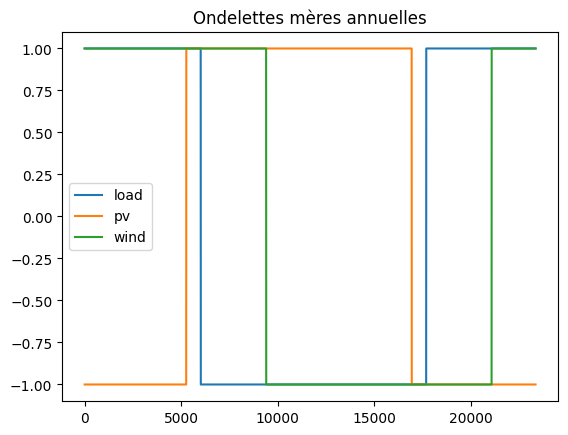

In [27]:
y0 = np.roll(vec_year, load[0][-1])[0]
y1 = np.roll(vec_year, pv[0][-1])[0]
y2 = np.roll(vec_year, wind[0][-1])[0]

plt.plot(y0, label ='load')
plt.plot(y1, label = 'pv')
plt.plot(y2, label = 'wind')
plt.legend()
plt.title("Ondelettes mères annuelles")

plt.show()

In [28]:
y0

array([1., 1., 1., ..., 1., 1., 1.])

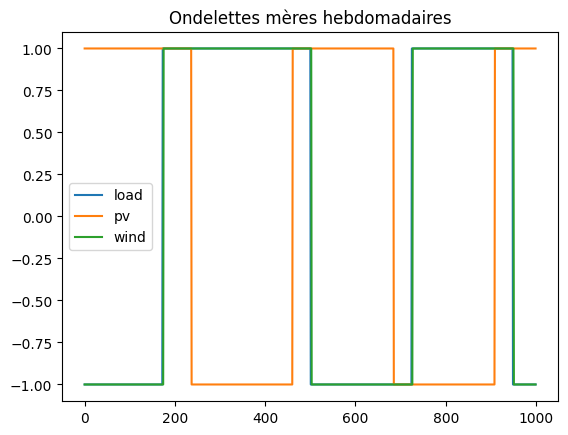

In [29]:
w0 = np.roll(vec_week_total[:1000], load[0][1])
w1 = np.roll(vec_week_total[:1000], pv[0][1])
w2 = np.roll(vec_week_total[:1000], wind[0][1])

plt.plot(w0, label ='load')
plt.plot(w1, label = 'pv')
plt.plot(w2, label = 'wind')
plt.legend()
plt.title("Ondelettes mères hebdomadaires")

plt.show()

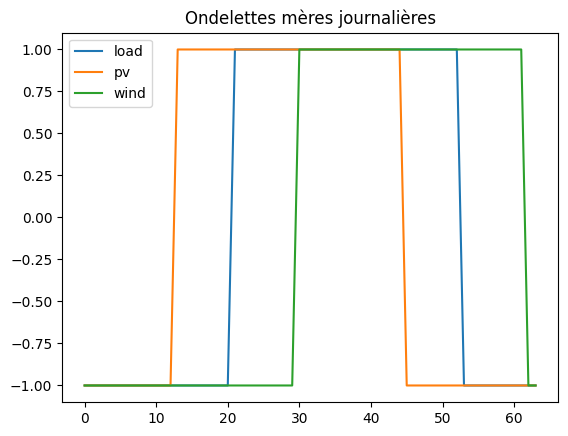

In [30]:
d0 = np.roll(vec_day_total[:64], load[0][0])
d1 = np.roll(vec_day_total[:64], pv[0][0])
d2 = np.roll(vec_day_total[:64], wind[0][0])

plt.plot(d0, label ='load')
plt.plot(d1, label = 'pv')
plt.plot(d2, label = 'wind')
plt.legend()
plt.title("Ondelettes mères journalières")

plt.show()

In [31]:
# def calculate_phase_shift(signal1, signal2):
#     cross_correlation = np.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
#     lag = np.argmax(cross_correlation) - len(signal1) + 1
#     return lag

In [32]:
import numpy as np

def calculate_phase_shift(signal1, signal2):
    # Détecter les fronts montants et descendants
    def find_edges(signal):
        edges = np.diff(signal)
        # print(edges)
        index = np.where(edges != 0)
        return index
    
    edges1 = find_edges(signal1)
    edges2 = find_edges(signal2)

    if len(edges1) == 0 or len(edges2) == 0:
        raise ValueError("No edges found in one or both signals.")
    
    # Calculer les décalages entre les premiers fronts détectés
    phase_differences = []
    for edge1 in edges1:
        nearest_edge2 = edges2[np.argmin(np.abs(edges2 - edge1))]
        phase_differences.append(edge1 - nearest_edge2)
    # print(phase_differences)
    # Prendre la valeur moyenne des décalages
    average_phase_difference = np.mean(phase_differences)
    
    return average_phase_difference


In [33]:
y0 = np.roll(vec_year, load[0][-1])[0]
y1 = np.roll(vec_year, pv[0][-1])[0]
y2 = np.roll(vec_year, wind[0][-1])[0]

lag_pv_year = calculate_phase_shift(y0, y1)

In [41]:
# Décalage entre les signaux
for country_name in countries:
    try: 
      
      pv = pd.read_pickle(f'translation_calculation_results/{country_name}_PV_ninja/translation/results_translation_justine_{country_name}_PV_ninja_bis.pkl')
      wind = pd.read_pickle(f'translation_calculation_results/{country_name}_Wind_ninja/translation/results_translation_justine_{country_name}_Wind_ninja_bis.pkl')
      load = pd.read_pickle(f'translation_calculation_results/{country_name}_PLEXOS/translation/results_translation_justine_{country_name}_PLEXOS_bis.pkl')
      print(pv)
      #----YEAR
      y0 = np.roll(vec_year, load[0][-1])[0]
      y1 = np.roll(vec_year, pv[0][-1])[0]
      y2 = np.roll(vec_year, wind[0][-1])[0]

      #---WEEK
      w0 = np.roll(vec_week_total[:1000], load[0][1])
      w1 = np.roll(vec_week_total[:1000], pv[0][1])
      w2 = np.roll(vec_week_total[:1000], wind[0][1])

      #---DAY
      d0 = np.roll(vec_day_total[:64], load[0][0])
      d1 = np.roll(vec_day_total[:64], pv[0][0])
      d2 = np.roll(vec_day_total[:64], wind[0][0])

      lag_pv_year = np.abs(load[0][-1]-pv[0][-1])
      lag_pv_day = np.abs(load[0][0]-pv[0][0])
      lag_pv_week = np.abs(load[0][1]-pv[0][1])
      print('Lag year pv: '+str(lag_pv_year))
      lag_wind_year = np.abs(load[0][-1]-wind[0][-1])
      lag_wind_day = np.abs(load[0][0]-wind[0][0])
      lag_wind_week = np.abs(load[0][1]-wind[0][1])
      print('Lag year wind: '+str(lag_wind_year))

      
      # lag_pv_year = calculate_phase_shift(y0, y1)
      # lag_pv_day = calculate_phase_shift(d0, d1)
      # lag_pv_week = calculate_phase_shift(w0, w1)
      # print('Lag year pv: '+str(lag_pv_year))
      # lag_wind_year = calculate_phase_shift(y0, y2)
      # lag_wind_day = calculate_phase_shift(d0, d2)
      # lag_wind_week = calculate_phase_shift(w0, w2)
      # print('Lag year wind: '+str(lag_wind_year))

      df = pd.DataFrame({"Country":[country_name],"Lag PV Year": [np.abs(lag_pv_year)], "Lag Wind Year":[np.abs(lag_wind_year)],
                        "Lag PV Week": [np.abs(lag_pv_week)], "Lag Wind Week":[np.abs(lag_wind_week)],
                          "Lag PV Day": [np.abs(lag_pv_day)], "Lag Wind Day":[np.abs(lag_wind_day)],})
      all_lags_file = "results/lags_world_diff_true.csv"
      file_exists = os.path.isfile(all_lags_file)
      df.to_csv(all_lags_file, mode='a', index=False, header=not file_exists)
    except:
       pass

In [42]:
# Corrélation entre les signaux 

for country_name in countries[:2]:
    try: 
      
      pv = pd.read_pickle(f'translation_calculation_results/{country_name}_PV_ninja/translation/results_translation_justine_{country_name}_PV_ninja_bis.pkl')
      wind = pd.read_pickle(f'translation_calculation_results/{country_name}_Wind_ninja/translation/results_translation_justine_{country_name}_Wind_ninja_bis.pkl')
      load = pd.read_pickle(f'translation_calculation_results/{country_name}_PLEXOS/translation/results_translation_justine_{country_name}_PLEXOS_bis.pkl')
      print(pv)
      #----YEAR
      y0 = np.roll(vec_year, load[0][-1])[0]
      y1 = np.roll(vec_year, pv[0][-1])[0]
      y2 = np.roll(vec_year, wind[0][-1])[0]

      #---WEEK
      w0 = np.roll(vec_week_total[:1000], load[0][1])
      w1 = np.roll(vec_week_total[:1000], pv[0][1])
      w2 = np.roll(vec_week_total[:1000], wind[0][1])

      #---DAY
      d0 = np.roll(vec_day_total[:64], load[0][0])
      d1 = np.roll(vec_day_total[:64], pv[0][0])
      d2 = np.roll(vec_day_total[:64], wind[0][0])

      
      corr_pv_load_year = np.corrcoef(y0,y1)
      corr_wind_load_year = np.corrcoef(y0,y2)

      corr_pv_load_day = np.corrcoef(d0,d1)
      corr_wind_load_day = np.corrcoef(d0,d2)

      df = pd.DataFrame({"Country":[country_name],"Corr Load PV Year": [corr_pv_load_year], "Corr Load Wind Year":[corr_wind_load_year],
                        "Corr Load PV Day": [corr_pv_load_day], "Corr Load Wind Day":[corr_wind_load_day]})
      all_lags_file = "results/corr_wavelets.csv"
      file_exists = os.path.isfile(all_lags_file)
      df.to_csv(all_lags_file, mode='a', index=False, header=not file_exists)
    except:
       pass

In [73]:
lag_pv_year = calculate_phase_shift(y0, y1)
print('Lag year pv: '+str(lag_pv_year))
lag_wind_year = calculate_phase_shift(y0, y2)
print('Lag year wind: '+str(lag_wind_year))

Lag year pv: -2229
Lag year wind: 2109


# Ondelette et signal d'origine : exemple France

In [94]:
country_name='Argentina'
pv = pd.read_pickle(f'translation_calculation_results/{country_name}_PV_ninja/translation/results_translation_justine_{country_name}_PV_ninja.pkl')
wind = pd.read_pickle(f'translation_calculation_results/{country_name}_Wind_ninja/translation/results_translation_justine_{country_name}_Wind_ninja.pkl')
load = pd.read_pickle(f'translation_calculation_results/{country_name}_PLEXOS/translation/results_translation_justine_{country_name}_PLEXOS.pkl')
print(pv)
#----YEAR
y0 = np.roll(vec_year, load[0][-1])[0]
y1 = np.roll(vec_year, pv[0][-1])[0]
y2 = np.roll(vec_year, wind[0][-1])[0]

#---WEEK
w0 = np.roll(vec_week_total[:1000], load[0][1])
w1 = np.roll(vec_week_total[:1000], pv[0][1])
w2 = np.roll(vec_week_total[:1000], wind[0][1])

#---DAY
d0 = np.roll(vec_day_total[:64], load[0][0])
d1 = np.roll(vec_day_total[:64], pv[0][0])
d2 = np.roll(vec_day_total[:64], wind[0][0])


[[27, 91, 16923]]


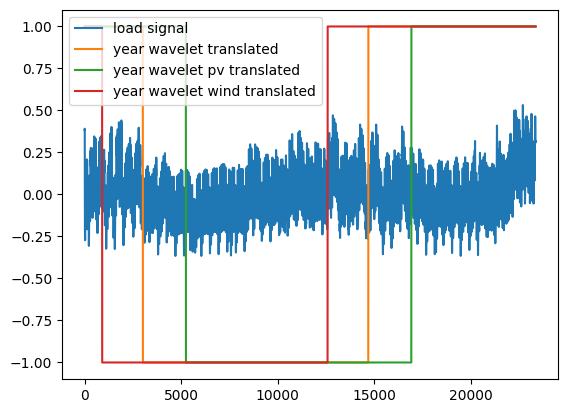

In [95]:
file_name = format_load_data(country_name)
Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
input_signal = Load_ts-Load_ts.mean()
y0 = np.roll(vec_year, load[0][-1])[0]
y1 = np.roll(vec_year, pv[0][-1])[0]
y2 = np.roll(vec_year, wind[0][-1])[0]
plt.plot(input_signal, label = 'load signal')
plt.plot(y0, label = 'year wavelet translated')
plt.plot(y1, label = 'year wavelet pv translated')
plt.plot(y2, label = 'year wavelet wind translated')
plt.legend()
plt.show()


In [96]:
print('Lag between PV and LOAD wavelets')
print(np.abs(load[0][-1]-pv[0][-1]))
print('Lag between WIND and LOAD wavelets')
print(np.abs(load[0][-1]-wind[0][-1]))

Lag between PV and LOAD wavelets
2229
Lag between WIND and LOAD wavelets
2109


: 

# Corrélation déphasage et résultats optim

In [42]:
import seaborn as sn
list_lags = pd.read_csv("results/lags_world_diff_true.csv", index_col=0)
for country_name in list_lags.index :
    result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
    list_lags.loc[country_name,'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name, 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
    list_lags.loc[country_name, 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)


In [43]:
list_lags

Lag PV Year  Lag Wind Year  Lag PV Week  Lag Wind Week  \
Country                                                                  
Afghanistan            1462           2756          138             63   
Albania                5449           7067          129             14   
Algeria               12857           3685          136             37   
Angola                 9547           9634           53             86   
Antarctica              783           9213          289             18   
...                     ...            ...          ...            ...   
Vietnam               14324           6505           52            275   
Western Sahara        12403           6041           48             47   
Yemen                 11508           3660          115            174   
Zambia                10761           9821            9            294   
Zimbabwe               2873           6574          135            302   

                Lag PV Day  Lag Wind Day  share_wind  share_pv  \
Country                                                          
Afghanistan             11             1    0.178950  0.692404   
Albania                  2             9    0.308150  0.577093   
Algeria                  8            27    0.584352  0.297513   
Angola                  10            22    0.113216  0.732760   
Antarctica              33            16    0.794988  0.136756   
...                    ...           ...         ...       ...   
Vietnam                 52            45    0.191856  0.652312   
Western Sahara          16            17    0.311633  0.588200   
Yemen                   13            16    0.410140  0.477311   
Zambia                   9            25    0.145041  0.690798   
Zimbabwe                 7            19    0.305944  0.589428   

                share_dispatch     cf_pv   cf_wind  
Country                                             
Afghanistan           0.128646  0.246219  0.107786  
Albania               0.114756  0.174821  0.159912  
Algeria               0.118135  0.213016  0.461972  
Angola                0.154024  0.185640  0.179414  
Antarctica            0.068256  0.166271  0.625593  
...                        ...       ...       ...  
Vietnam               0.155832  0.167239  0.183071  
Western Sahara        0.100166  0.205352  0.441926  
Yemen                 0.112549  0.220067  0.234778  
Zambia                0.164161  0.198744  0.299732  
Zimbabwe              0.104628  0.212620  0.261436  

[161 rows x 11 columns]

<Axes: >

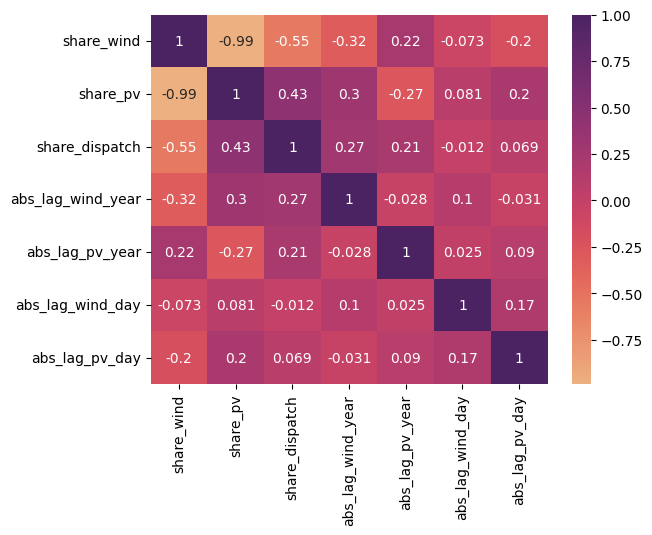

In [86]:
cols = ['share_wind', 'share_pv','share_dispatch', 'abs_lag_wind_year','abs_lag_pv_year', 'abs_lag_wind_day','abs_lag_pv_day'] 
corr_matrix = list_lags[cols].corr()
sn.heatmap(corr_matrix, annot =True, cmap = 'flare')

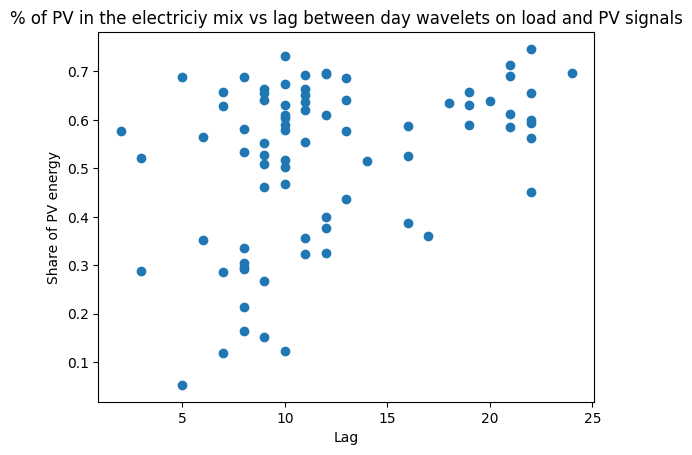

In [77]:
plt.scatter(list_lags['abs_lag_pv_day'], list_lags['share_pv'])
plt.title('% of PV in the electriciy mix vs lag between day wavelets on load and PV signals')
plt.xlabel('Lag')
plt.ylabel('Share of PV energy')
plt.show()

# Correlation corrélation résultats optim

In [26]:
# import seaborn as sn
# list_lags = pd.read_csv("results/corr_wavelets.csv", index_col=0)
# for country_name in list_lags.index :
#     result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
#     list_lags.loc[country_name,'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
#     list_lags.loc[country_name,'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
#     list_lags.loc[country_name,'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])


# Régression linéaire multiple

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Vérification de la multicolinéarité avec VIF :")
print(vif_data)

Vérification de la multicolinéarité avec VIF :
         feature        VIF
0    Lag PV Year   4.450690
1  Lag Wind Year   2.682460
2    Lag PV Week   3.553044
3  Lag Wind Week   3.051358
4     Lag PV Day   2.537271
5   Lag Wind Day   3.234940
6          cf_pv  13.063207
7        cf_wind   5.167869


# PCA

In [92]:
features = list_lags[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']]
features_scaled = StandardScaler().fit_transform(list_lags)

In [94]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

In [97]:
finalDf = pd.concat([principalDf, list_lags[['share_pv']]], axis=1)

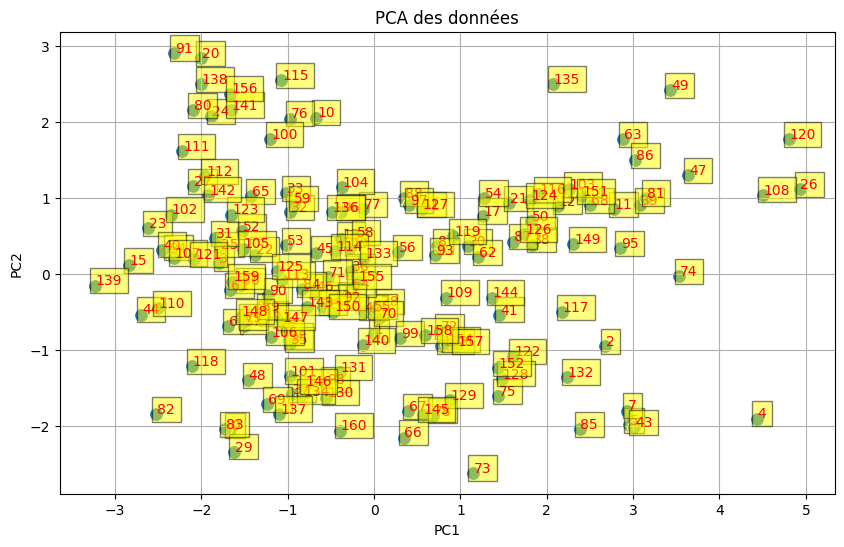

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=principalDf, s=100)
for i in principalDf.index:
    plt.text(x=principalDf.PC1[i]+0.01, y=principalDf.PC2[i]+0.01, s=i, 
             fontdict=dict(color='red', size=10),
             bbox=dict(facecolor='yellow', alpha=0.5))
plt.title('PCA des données')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

In [109]:
# Composantes principales (vecteurs propres)
components = pca.components_

# Affichage des vecteurs propres
print("Vecteurs propres (composantes principales) :")
print(components)

# Affichage sous forme de DataFrame pour une meilleure lisibilité
components_df = pd.DataFrame(components, columns=list_lags.columns, index=['PC1', 'PC2'])
print(components_df)

Vecteurs propres (composantes principales) :
[[ 0.1428409  -0.23616529 -0.06170773 -0.14293658 -0.13907747 -0.0274586
   0.54433197 -0.53283885 -0.33951622 -0.19901251  0.37999399]
 [ 0.47948394 -0.11048139 -0.16653941 -0.03049677  0.39414769  0.047382
   0.02252202 -0.08472865  0.36938491 -0.59450786 -0.27213075]]
     Lag PV Year  Lag Wind Year  Lag PV Week  Lag Wind Week  Lag PV Day  \
PC1     0.142841      -0.236165    -0.061708      -0.142937   -0.139077   
PC2     0.479484      -0.110481    -0.166539      -0.030497    0.394148   

     Lag Wind Day  share_wind  share_pv  share_dispatch     cf_pv   cf_wind  
PC1     -0.027459    0.544332 -0.532839       -0.339516 -0.199013  0.379994  
PC2      0.047382    0.022522 -0.084729        0.369385 -0.594508 -0.272131  


In [104]:
tsne = TSNE(n_components=2, perplexity=3, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)
tsneDf = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'], index=list_lags.index)

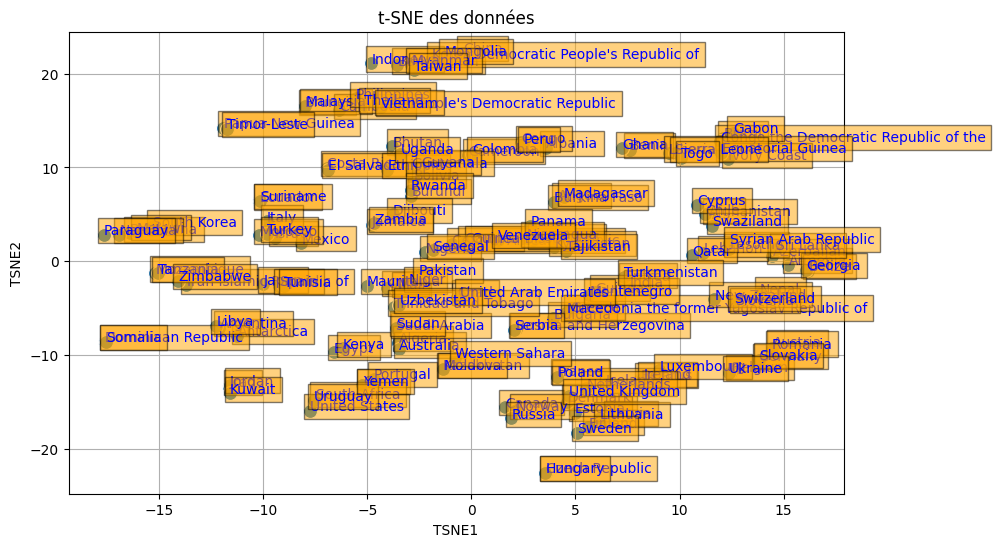

In [105]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', data=tsneDf, s=100)
for i in tsneDf.index:
    plt.text(x=tsneDf.TSNE1[i]+0.01, y=tsneDf.TSNE2[i]+0.01, s=i, 
             fontdict=dict(color='blue', size=10),
             bbox=dict(facecolor='orange', alpha=0.5))
plt.title('t-SNE des données')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid()
plt.show()

In [107]:
manova = MANOVA.from_formula('Q("Lag PV Year") + Q("Lag Wind Year") + Q("Lag PV Week") + Q("Lag Wind Week") + Q("Lag PV Day") + Q("Lag Wind Day") + share_wind + share_pv + share_dispatch + cf_pv + cf_wind ~ 1', data=list_lags)
print(manova.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value          Num DF  Den DF         F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 11.0000 150.0000 20470907397138604.0000 0.0000
         Pillai's trace                1.0000 11.0000 150.0000 20470907397138604.0000 0.0000
 Hotelling-Lawley trace 1501199875790164.2500 11.0000 150.0000 20470907397138604.0000 0.0000
    Roy's greatest root 1501199875790164.2500 11.0000 150.0000 20470907397138604.0000 0.0000



# Calcul des ondelettes

In [17]:
for country in countries[91:92]:
    file_name = format_load_data(country)
    Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
    
    # Options of the wavelet decomposition
    vy = 1  # number of vectors per years (child wavelets)
    vw = 1  # vectors per week
    vd = 1  # vectors per day

    # Time scales of the wavelet decomposition
    time_scales = [24., 168.,  8760.] # cycles length, in hours

    translation_name = f'{country}_PLEXOS'
    translation_results_root = 'translation_calculation_results/' + translation_name 

    path_trans = translation_results_root + '/translation/'
    create_directory(path_trans)
    path_matrix = translation_results_root + '/matrix/'
    create_directory(path_matrix)

    wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
    input_data = Load_ts

    #Calculate translations
    trans = calc_all_translations_justine(path_trans, translation_name,
                                    ndpd, dpy, input_data, wl_shape='square', 
                                    recompute_translation= False)
    
    #Calculate wavelet decomposition
    input_data = Load_ts

    beta_path = f'results_decomposition_coefficient/Plexos/{country}/'
    stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(input_data,
                vy, vw, vd, dpy, ndpd,
                trans,
                path_matrix,
                beta_path, wl_shape ='square', imp_matrix = False,
                years = ['2015'])

    # #Plot betas heatmaps
    # list_of_keys = list(per_year_betas.keys())

    # # First, select the year that must be plotted
    # year = list_of_keys[0]
    # years = list_of_keys
    # print("Selected Year for heatmap plot:", year)
    # print("Total number of year:", list_of_keys)

    # name = f'{country} demand' # Name printed in the heatmap title

    # # Replace square by sine for the sine wavelet decomposition
    # matrix_name = 'A_'+ year+'.npz'
    # if not os.path.isfile(f'heatmaps/load_heatmap_plexos_{country}.png'):
    #     A_sparse  = sparse.load_npz(path_matrix + matrix_name)
    #     A = sparse.csr_matrix.todense(A_sparse)
    #     matrix = np.asarray(A)

    #     df = preplotprocessing(vy, vw , vd, ndpd, dpy, 
    #                         year, years,
    #                         time_scales,
    #                         per_year_betas, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
    #                         matrix)

    #     plot_betas_heatmap(df, name , year , ndpd,
    #                         cmin= -0.1,
    #                         cmax= 0.1,
    #                         ccenter = None, save_fig = f'heatmaps/load_heatmap_plexos_{country}')
            

Directory 'translation_calculation_results/Libya_PLEXOS/translation/' already exists.
Directory 'translation_calculation_results/Libya_PLEXOS/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Libya_PLEXOS/translation/results_translation_justine_Libya_PLEXOS.pkl
Directory 'results_decomposition_coefficient/Plexos/Libya/' already exists.
translation_calculation_results/Libya_PLEXOS/matrix/A_2015.npz
[[20, 340, 6420]]
Computing Matrix A square
Square sparsee matrix or year 2015 has been imported


In [9]:
for country_name in ['Australia', 'Russia', 'China', 'Canada', 'United States', 'Brazil']:
# for country_name in ['Australia']:
    print(country_name)
    regions_match = pd.read_excel('match_plexos_iso_codes.xlsx')
    regions_match = regions_match[regions_match['Country']==country_name].set_index('region')
    states_list = dict_list[country_name]
    print(states_list)
    for state in states_list: 
        region_name = regions_match.loc[state, 'plexos']
        print(region_name)
        file_name = format_load_data(country_name, state_name=region_name)
        Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
    
        # Options of the wavelet decomposition
        vy = 1  # number of vectors per years (child wavelets)
        vw = 1  # vectors per week
        vd = 1  # vectors per day

        # Time scales of the wavelet decomposition
        time_scales = [24., 168.,  8760.] # cycles length, in hours

        translation_name = f'{country_name}_{region_name}_PLEXOS'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = Load_ts

        #Calculate translations
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)
        
        #Calculate wavelet decomposition
        input_data = Load_ts

        beta_path = f'results_decomposition_coefficient/Plexos/{country_name}/{region_name}/'
        stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(input_data,
                    vy, vw, vd, dpy, ndpd,
                    trans,
                    path_matrix,
                    beta_path, wl_shape ='square', imp_matrix = True,
                    years = ['2015'])


Australia
['NSW', 'QLD', 'SA', 'WA', 'VIC', 'TAS', 'NT', 'NSW', 'QLD', 'SA', 'WA', 'VIC', 'TAS', 'NT']
SW
Directory 'translation_calculation_results/Australia_SW_PLEXOS/translation/' already exists.
Directory 'translation_calculation_results/Australia_SW_PLEXOS/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Australia_SW_PLEXOS/translation/results_translation_justine_Australia_SW_PLEXOS.pkl
Directory 'results_decomposition_coefficient/Plexos/Australia/SW/' already exists.
translation_calculation_results/Australia_SW_PLEXOS/matrix/A_2015.npz
[[62, 316, 6781]]
Importing matrix A square
Square sparsee matrix or year 2015 has been imported
QL
Directory 'translation_calculation_results/Australia_QL_PLEXOS/translation/' already exists.
Directory 'translation_calculation_results/Australia_QL_PLEXOS/matrix/

# Wavelet decomposition PV

In [10]:
for country_name in countries[:2]:
    folder = path_input_data + f'/{country_name}'
    partie_name_file = f'grid_locations_averaged_pv_{country_name}_2021.xlsx' 

    chemin_pattern = os.path.join(folder, f'*{partie_name_file}*')
    fichiers_trouves = glob.glob(chemin_pattern)
    print(fichiers_trouves)
    if len(fichiers_trouves)!=0:
        file_name = fichiers_trouves[0].split('/',2)[-1]
        PV_ts = import_excel(path_input_data,file_name, 
                                        dpd ,ndpd, dpy, 
                                        interp=True, norm = None) # interpolate data from dpd to ndpd numper of points per day

    # Options of the wavelet decomposition
    vy = 1  # number of vectors per years (child wavelets)
    vw = 1  # vectors per week
    vd = 1  # vectors per day

    # Time scales of the wavelet decomposition
    time_scales = [24., 168.,8760.] # cycles length, in hours

    translation_name = f'{country}_PV_ninja'
    translation_results_root = 'translation_calculation_results/' + translation_name 

    path_trans = translation_results_root + '/translation/'
    create_directory(path_trans)
    path_matrix = translation_results_root + '/matrix/'
    create_directory(path_matrix)

    wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
    input_data = PV_ts

    #Calculate translations
    trans = calc_all_translations_justine(path_trans, translation_name,
                                    ndpd, dpy, input_data, wl_shape='square', 
                                    recompute_translation= False)
    
    #Calculate wavelet decomposition
    input_data = PV_ts

    beta_path = f'results_decomposition_coefficient/Plexos/{country_name}_PV/'
    stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(input_data,
                vy, vw, vd, dpy, ndpd,
                trans,
                path_matrix,
                beta_path, wl_shape ='square', imp_matrix = False,
                years = ['2015'])


['../input_time_series//Afghanistan\\ren_ninja_1_grid_locations_averaged_pv_Afghanistan_2021.xlsx']
Directory 'translation_calculation_results/Afghanistan_PV_ninja/translation/' already exists.
Directory 'translation_calculation_results/Afghanistan_PV_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Afghanistan_PV_ninja/translation/results_translation_justine_Afghanistan_PV_ninja.pkl
Directory 'results_decomposition_coefficient/Plexos/Afghanistan_PV/' created successfully.
translation_calculation_results/Afghanistan_PV_ninja/matrix/A_2015.npz
[[3, 195, 8067]]
Computing Matrix A square
Square sparsee matrix or year 2015 has been imported
['../input_time_series//Albania\\ren_ninja_2_grid_locations_averaged_pv_Albania_2021.xlsx']
Directory 'translation_calculation_results/Afghanistan_PV_ninja/tran

In [ ]:
for country_name in ['Australia', 'Russia', 'China', 'Canada', 'United States', 'Brazil']:
# for country_name in ['Australia']:
    print(country_name)
    regions_match = pd.read_excel('match_plexos_iso_codes.xlsx')
    regions_match = regions_match[regions_match['Country']==country_name].set_index('region')
    states_list = dict_list[country_name]
    print(states_list)
    for state in states_list: 
        region_name = regions_match.loc[state, 'plexos']
        print(region_name)
        file_name = format_load_data(country_name, state_name=region_name)
        Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
    
        # Options of the wavelet decomposition
        vy = 1  # number of vectors per years (child wavelets)
        vw = 1  # vectors per week
        vd = 1  # vectors per day

        # Time scales of the wavelet decomposition
        time_scales = [24., 168.,  8760.] # cycles length, in hours

        translation_name = f'{country_name}_{region_name}_PLEXOS'
        translation_results_root = 'translation_calculation_results/' + translation_name 

        path_trans = translation_results_root + '/translation/'
        create_directory(path_trans)
        path_matrix = translation_results_root + '/matrix/'
        create_directory(path_matrix)

        wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
        input_data = Load_ts

        #Calculate translations
        trans = calc_all_translations_justine(path_trans, translation_name,
                                        ndpd, dpy, input_data, wl_shape='square', 
                                        recompute_translation= False)
        
        #Calculate wavelet decomposition
        input_data = Load_ts

        beta_path = f'results_decomposition_coefficient/Plexos/{country_name}/{region_name}/'
        stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(input_data,
                    vy, vw, vd, dpy, ndpd,
                    trans,
                    path_matrix,
                    beta_path, wl_shape ='square', imp_matrix = True,
                    years = ['2015'])

# Wavelet decomposition Wind

In [9]:
for country in countries[:]:
    file_name = format_load_data(country)
    Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True, norm = 'mean')
    
    # Options of the wavelet decomposition
    vy = 1  # number of vectors per years (child wavelets)
    vw = 1  # vectors per week
    vd = 1  # vectors per day

    # Time scales of the wavelet decomposition
    time_scales = [24., 168.,8760.] # cycles length, in hours

    translation_name = f'{country}_Wind_ninja'
    translation_results_root = 'translation_calculation_results/' + translation_name 

    path_trans = translation_results_root + '/translation/'
    create_directory(path_trans)
    path_matrix = translation_results_root + '/matrix/'
    create_directory(path_matrix)

    wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
    input_data = Load_ts

    #Calculate translations
    trans = calc_all_translations_justine(path_trans, translation_name,
                                    ndpd, dpy, input_data, wl_shape='square', 
                                    recompute_translation= False)
    
    #Calculate wavelet decomposition
    input_data = Load_ts

    beta_path = f'results_decomposition_coefficient/Plexos/{country}/'
    stacked_betas, per_year_betas = compute_wavelet_coefficient_betas(input_data,
                vy, vw, vd, dpy, ndpd,
                trans,
                path_matrix,
                beta_path, wl_shape ='square', imp_matrix = True,
                years = ['2015'])


Directory 'translation_calculation_results/Afghanistan_Wind_ninja/translation/' already exists.
Directory 'translation_calculation_results/Afghanistan_Wind_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\optim_mix\translation_calculation_results/Afghanistan_Wind_ninja/translation/results_translation_justine_Afghanistan_Wind_ninja.pkl
Directory 'results_decomposition_coefficient/Plexos/Afghanistan/' already exists.
translation_calculation_results/Afghanistan_Wind_ninja/matrix/A_2015.npz
[[15, 270, 3849]]
Computing Matrix A square
Square sparsee matrix or year 2015 has been imported
Directory 'translation_calculation_results/Albania_Wind_ninja/translation/' already exists.
Directory 'translation_calculation_results/Albania_Wind_ninja/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace c

In [13]:
Dt = dpy * ndpd
vec_year = np.zeros((1, signal_length))
vec_year[0, 0:  Dt // 2] = 1.  # /math.sqrt(Dt)
vec_year[0, Dt // 2:  Dt] = -1.  # /math.sqrt(Dt)
signal = Load_ts-Load_ts.mean()
plt.plot(signal)
plt.plot(np.roll(vec_year[0], trans_justine[0][1]), label = 'scalar product')

plt.legend()
plt.title("Reconstruction du signal et signal d'origine par deux méthodes")
plt.show()

: 

: 

In [ ]:
# Calc and save E, P, N
epn_file = "results/E_P_N_Plexos.csv"
file_exists = os.path.isfile(epn_file)

print(f"Data have been added to {epn_file}")  
load_factor=54000
for country in countries : 
    scenario_name = f'{country} Plexos'
    beta_path = f'./results_decomposition_coefficient/Plexos/{country}'
    stacked_betas_conso = pd.read_excel(f'{country}results_betas_stacked.xlsx')
    pmc = stacked_betas_conso

    satisfactions = [80,95,99,100] # Satisfaction rate

    satisfaction_labels = [str(satis)+'%' for satis in satisfactions]

    results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
    results.to_csv(epn_file, mode='a', index=False, header=not file_exists)